# Time Series Prediction with Knowledge Based Deep Learning ($KDL$)



AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-06 21:43:33

## Gathering Dependencies

_Importing Required Libraries_

In [29]:
pip install hampel

You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Pretraining

_Lienard intermittancy_

The `lienard_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lienard System

In [31]:
data = np.genfromtxt('datasets/lienard_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [32]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

1.00123132
1         7.142857e-07
2         1.421429e-06
3         2.124286e-06
4         2.810000e-06
5         3.481429e-06
              ...     
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
139870    0.000000e+00
139871    0.000000e+00
Name: 1, Length: 139871, dtype: float64
2         1.010204e-07
3         1.004082e-07
4         9.795918e-08
5         9.591837e-08
6         9.244898e-08
              ...     
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
139870    0.000000e+00
139871    0.000000e+00
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_EL NINO_

In [33]:
data = pd.read_csv("datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


In [34]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         7.142857e-07
1         1.421429e-06
2         2.124286e-06
3         2.810000e-06
4         3.481429e-06
              ...     
139866    0.000000e+00
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
139870    0.000000e+00
Name: 1, Length: 139871, dtype: float64
0         1.010204e-07
1         1.004082e-07
2         9.795918e-08
3         9.591837e-08
4         9.244898e-08
              ...     
139865    0.000000e+00
139866    0.000000e+00
139867    0.000000e+00
139868    0.000000e+00
139869    0.000000e+00
Name: 1, Length: 139870, dtype: float64


In [35]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Lienard Systems_)

<AxesSubplot:>

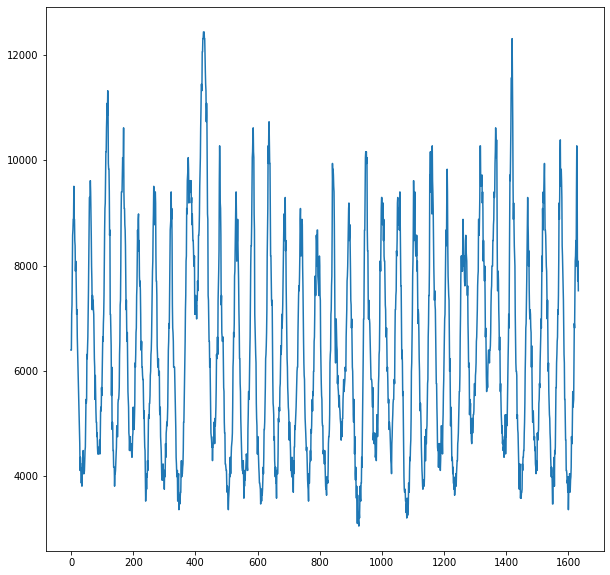

In [36]:
a = 0.45
b = 0.5
c = -0.5
L = df.iloc[:,2] + a*df.iloc[:,0]*df.iloc[:,1] +c*df.iloc[:,0] +b* df.iloc[:,0]**3
L.plot()

## Preprocessing the data into supervised learning

In [37]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)  # ,18,19
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)

    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        23.4       23.4       24.2       24.4       25.1       25.8   
11        23.4       24.2       24.4       25.1       25.8       25.9   
12        24.2       24.4       25.1       25.8       25.9       26.1   
13        24.4       25.1       25.8       25.9       26.1       26.1   
14        25.1       25.8       25.9       26.1       26.1       26.7   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)  \
10       25.9       26.1       26.1       26.7     26.1  0.000007   
11       26.1       26.1       26.7       26.1     26.1  0.000007   
12       26.1       26.7       26.1       26.1     25.7  0.000008   
13       26.7       26.1       26.1       25.7     25.6  0.000008   
14       26.1       26.1       25.7       25.6     25.1  0.000008   

         var3(t)  
10  6.081633e-08  
11  5.326531e-08  
12  4.510204e-08  
13  3.653061e-08  
14  2.734694e-08  
Index(['var1(t-10)', 'var1(t-9)'

## Train and Test Split

In [38]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1298, 1, 10) (1298, 3) (325, 1, 10) (325, 3)


## Defining the Physical Loss

In [39]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def phys(y_pred, y_true):
    return mean_absolute_error(y_true[:,2] + a*y_true[:,0]*y_true[:,1] +c*y_true[:,0] +b* y_true[:,0]**3, y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] +a*y_pred[:-2]*(y_pred[1:-1]-y_pred[:-2]) +c*y_pred[:-2] +b* y_pred[:-2]**3
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] +a*y_real[:-2]*(y_real[1:-1]-y_real[:-2]) +c*y_real[:-2] +b* y_real[:-2]**3
    return(mean_absolute_error(pred,real))

## Model ($KDL$)

In [40]:
a = tf.Variable(0.45, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.5, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(-0.5, name="c", trainable=True, dtype=tf.float32)
def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:,0] - y_pred[:,0])
    squared_difference2 = tf.square(y_true[:,2]-y_pred[:,2])
    squared_difference1 = tf.square(y_true[:,1]-y_pred[:,1])    
    squared_difference3 = tf.square(y_pred[:,2] + a*y_pred[:,0]*y_pred[:,1] +c*y_pred[:,0] +b* y_pred[:,0]**3)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False)

Epoch 1/500
21/21 [==============================] - 4s 43ms/step - loss: 0.1868 - val_loss: 0.0901
Epoch 2/500
21/21 [==============================] - 0s 9ms/step - loss: 0.0392 - val_loss: 0.0168
Epoch 3/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0160
Epoch 4/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0148
Epoch 5/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 6/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 7/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 8/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 10/500
21/21 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 11

## Metrics ($KDL$)

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

11/11 [==============================] - 0s 1ms/step
(325, 3)
(325, 10)
Test RMSE: 0.430
Test MAE: 0.335


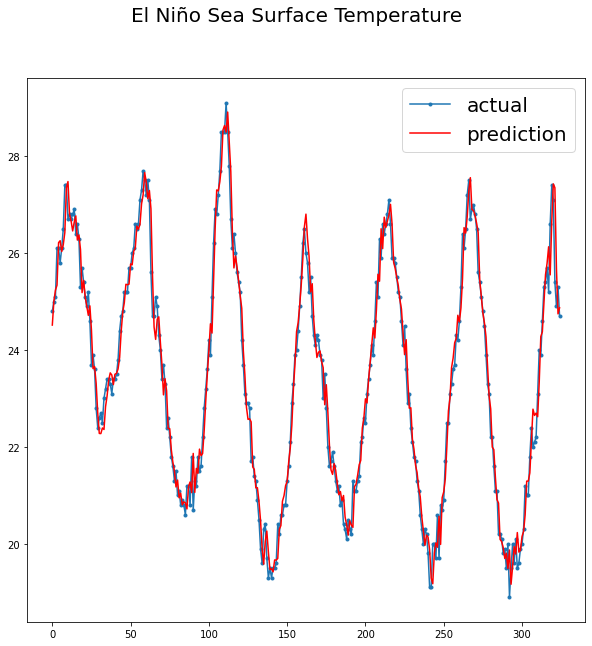

In [42]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()